## Calculating mass, radius and moment of inertia

We start by importing the relevant functions from the files "Generate_Params_Par.py" and "Create_MRcurves_Par.py".

In [1]:
from Generate_Params_Par import generate_params, calc_causal_limit, calc_maxrho
from Create_MRcurves_Par import crust_EOS, calculate_MR, calculate_MR_all
import numpy
from scipy.signal import argrelextrema
from matplotlib import pyplot

In [19]:
#help(generate_params)
#help(calc_maxrho)
#help(calculate_MR_all)

First we create the input parameters, for each EoS we have three parameters setting the pressure at three fixed 
densities, with a piecewise polytrope in between. Here we choose the mininum and maximum polytropic index 
that is allowed to be 0.5 and 5.5 respectively and the number of points for each parameter to be 4.

In [20]:
ParametersInput = generate_params(4, .5, 5.5)
len(ParametersInput)

25

Next we calculate for each set of parameters the maximum density for which the EoS is still causal, i.e. c$_s$< c

In [22]:
max_rho = calc_maxrho(ParametersInput)
max_rho

array([  3.16227766e+16,   2.47139943e+15,   2.70422013e+16,
         1.42558788e+15,   3.16227766e+16,   2.48390588e+15,
         2.74548211e+16,   1.43280202e+15,   9.56777185e+14,
         9.56777185e+14,   9.56777185e+14,   2.81565591e+16,
         1.44005268e+15,   3.16227766e+16,   1.83486283e+15,
         9.96204154e+14,   7.28504825e+14,   7.28504825e+14,
         2.93168373e+16,   1.46202553e+15,   3.16227766e+16,
         1.91047404e+15,   9.96204154e+14,   7.35896635e+14,
         7.35896635e+14])

To solve the TOV-equations we have to first load the functions for the crust EoS and it's inverse. P_min is the minimum pressure for which this EoS is defined. Then we calculate the masses, radii and moments of inertia for each EoS. Some mass-radius curves
are not stable, so these are discarded. This means that the output Parameters can contain less EoSs than the 
input parameters.

In [24]:
eos_crust, inveos_crust, P_min = crust_EOS()
MRIcurves, Parameters = calculate_MR_all(ParametersInput, eos_crust, inveos_crust, P_min=P_min, n=80, 
                                        logrhomax =numpy.log10(max_rho))

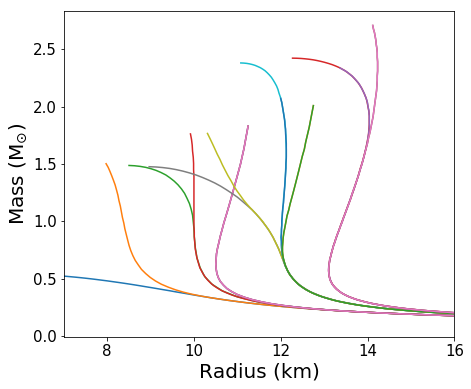

In [25]:
fig, ax = pyplot.subplots(1,1, figsize=(7,6))
for i in range(len(MRIcurves)):
    M, R, I = MRIcurves[i]
    ax.plot(R, M)
ax.set_xlim(7, 16)
ax.set_xlabel('Radius (km)', fontsize=20)
ax.set_ylabel(r'Mass (M$_{\odot}$)', fontsize=20)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
pyplot.show()